In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import os

In [2]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [111]:
DATA_DIR = os.path.join(os.getcwd(), '../data/safety/kfengtee.csv')

adaboost_cols = ['second_mean', 'speed_mean', 'speed_median', 'second_spread',
       'acceleration_std', 'num_non_speed_outlier', 'second_std',
       'second_median', 'speed_spread', 'num_non_gyro_outlier', 'label']

agg_diff_df = pd.read_csv(DATA_DIR)
agg_diff_df = agg_diff_df.drop('bookingid', axis='columns')
agg_diff_df = agg_diff_df[adaboost_cols]
agg_diff_df.head(n=10)

,second_mean,speed_mean,speed_median,second_spread,acceleration_std,num_non_speed_outlier,second_std,second_median,speed_spread,num_non_gyro_outlier,label
0,903.526892,8.994822,8.503366,1589.0,0.624159,243,533.745097,1087.5,23.946083,239,0
1,581.175088,7.881588,6.904588,1034.0,0.519956,189,289.339367,607.0,22.882141,199,1
2,339.441026,3.157213,2.998761,825.0,0.515173,47,356.319445,97.0,9.360483,41,1
3,547.495430,6.150996,3.310000,1094.0,0.620066,260,315.962793,547.5,19.780001,245,1
4,547.000000,4.628921,1.936962,1094.0,0.585346,263,316.243577,547.0,16.394695,253,0
5,480.947313,12.176386,13.017325,959.0,0.916836,221,276.761488,481.0,25.230654,235,0
6,256.847545,5.351266,3.500000,462.0,0.728514,92,130.713942,268.0,19.270000,88,0
7,187.000000,8.702027,9.580000,374.0,0.833292,89,108.397417,187.0,20.050000,82,0
8,132.000000,6.659024,5.192059,299.0,0.750480,46,93.043769,112.0,17.876741,43,0
9,299.500000,4.725448,3.173314,599.0,0.447980,140,173.349358,299.5,21.780035,140,0


In [66]:
# # Downsampling training set to get equal class distribution
# seed = 199

# np.random.seed(seed)

# count_0 = agg_diff_df['label'].value_counts()[0]
# count_1 = agg_diff_df['label'].value_counts()[1]

# idx0 = agg_diff_df[agg_diff_df['label'] == 0].index.values
# sample_0_idx = np.random.choice(idx0, size=count_1, replace=False)

# df_0 = agg_diff_df.iloc[sample_0_idx, :]
# downsample_df = pd.concat([df_0, agg_diff_df[agg_diff_df['label'] == 1]]).sample(frac=1).reset_index(drop=True)

# X = downsample_df.drop('label', axis=1)
# y = downsample_df['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

In [69]:
# # Reforming test set to have class distribution of 75% class 0 : 25% class 1
# prop = count_1 / (count_0 + count_1)
# sample_0_idx2 = [idx for idx in idx0 if idx not in sample_0_idx]

# count_1_new = y_test2.value_counts()[1]
# count_0_new = y_test2.value_counts()[0]
# size_total = np.int((count_1_new / 20) * 80)
# size_rem = size_total - count_0_new

# sample_0_idx2 = np.random.choice(sample_0_idx2, size=size_rem, replace=False)

# new_df0 = agg_diff_df.iloc[sample_0_idx2, :]

# X_test = pd.concat([X_test, new_df0.drop('label', axis=1)]).sample(frac=1)
# y_test = pd.concat([y_test, new_df0['label']]).sample(frac=1)

In [112]:
seed = 102

np.random.seed(seed)

X = agg_diff_df.drop('label', axis=1)
y = agg_diff_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=seed, shuffle=True)

print(y_train.value_counts())
print(y_test.value_counts())

0    11967
1     4018
Name: label, dtype: int64
0    3032
1     965
Name: label, dtype: int64


In [113]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train_scaled.describe()

,second_mean,speed_mean,speed_median,second_spread,acceleration_std,num_non_speed_outlier,second_std,second_median,speed_spread,num_non_gyro_outlier
count,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04,1.598500e+04
mean,1.459978e-17,-4.543198e-16,8.059448e-17,1.783276e-17,4.212388e-17,1.121475e-16,-7.290212e-17,8.946376e-17,-1.661063e-16,7.039168e-17
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.137380e-02,-2.194757e+00,-1.562373e+00,-1.446772e-02,-1.632869e+00,-1.823856e+00,-1.393694e-02,-1.518703e+00,-3.847519e+00,-1.754359e+00
25%,-1.086632e-02,-7.411859e-01,-7.681883e-01,-1.443784e-02,-4.432735e-01,-7.619954e-01,-1.386320e-02,-7.267819e-01,-6.905334e-01,-7.715878e-01
50%,-1.050896e-02,-2.206701e-01,-2.369787e-01,-1.441723e-02,-1.615945e-01,-1.552177e-01,-1.381280e-02,-1.425201e-01,1.335398e-02,-1.585719e-01
75%,-1.006794e-02,5.816500e-01,5.940225e-01,-1.439147e-02,1.869026e-01,6.234804e-01,-1.375334e-02,5.666894e-01,7.432251e-01,6.393218e-01
max,1.219359e+02,4.919532e+00,3.954529e+00,1.027395e+02,2.019433e+01,1.673343e+01,1.024543e+02,2.391253e+01,2.322740e+01,1.223797e+01


In [114]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test_scaled.describe()

,second_mean,speed_mean,speed_median,second_spread,acceleration_std,num_non_speed_outlier,second_std,second_median,speed_spread,num_non_gyro_outlier
count,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03,3.997000e+03
mean,-4.116984e-18,-4.527277e-16,6.751750e-17,1.969695e-17,-1.249938e-16,-9.396759e-17,-7.129857e-18,7.021876e-17,1.037171e-16,1.213829e-16
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,-2.343577e-02,-2.200054e+00,-1.555848e+00,-1.589975e-02,-1.527091e+00,-1.847147e+00,-1.612719e-02,-1.587899e+00,-3.999681e+00,-1.762144e+00
25%,-1.930302e-02,-7.323201e-01,-7.607036e-01,-1.585534e-02,-4.337218e-01,-7.478590e-01,-1.595486e-02,-7.468301e-01,-7.102989e-01,-7.739631e-01
50%,-1.658790e-02,-2.311273e-01,-2.468733e-01,-1.582624e-02,-1.591734e-01,-1.359911e-01,-1.584314e-02,-1.498213e-01,-1.215461e-03,-1.612908e-01
75%,-1.294342e-02,5.862923e-01,5.954278e-01,-1.578948e-02,1.739295e-01,6.106952e-01,-1.570425e-02,6.067654e-01,7.405672e-01,6.292540e-01
max,6.321323e+01,4.014485e+00,3.664321e+00,6.321392e+01,1.615867e+01,7.818292e+00,6.321392e+01,6.636930e+00,4.243975e+00,8.386476e+00


In [117]:
def build_model(num_layers=1, num_nodes=32, lr=0.001, dropout=False, opt="SGD", input_shape=(10,)):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))
    
    if dropout:
        model.add(Dropout(rate=0.5))
    
    if num_layers > 1:
        for i in range(num_layers - 1):
            model.add(Dense(num_nodes, activation='relu'))
            if dropout:
                model.add(Dropout(rate=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if opt == "SGD":
        optimiser = optimizers.SGD(lr=lr)
    elif opt == "RMSprop":
        optimiser = optimizers.RMSprop(lr=lr)
    elif opt == "Adam":
        optimiser = optimizers.Adam(lr=lr)
    
    model.compile(loss="binary_crossentropy", 
               optimizer=optimiser,
               metrics=["accuracy"])
            
    return model

In [118]:
import datetime
start_time = datetime.datetime.now()

k = 5
num_val_samples = X_train_scaled.shape[0] // k
num_epochs = 20
batch_size = 16
all_val_loss = []
all_train_loss = []
all_val_acc = []
all_train_acc = []

for i in range(k):
    print('Processing fold {} of {}'.format(i + 1, k))

    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], 
                                         X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], 
                                            y_train[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model(num_layers=2, num_nodes=256, lr=0.001, opt="Adam", dropout=True)
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, verbose=0,
                        validation_data=((val_data, val_targets)), batch_size=batch_size)

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    all_val_loss.append(val_loss)
    all_train_loss.append(loss)
    all_val_acc.append(val_acc)
    all_train_acc.append(acc)

    end_time = datetime.datetime.now()
    print("Total time taken: {} seconds".format((end_time - start_time).seconds))

Processing fold 1 of 5
Total time taken: 121 seconds
Processing fold 2 of 5
Total time taken: 245 seconds
Processing fold 3 of 5
Total time taken: 376 seconds
Processing fold 4 of 5
Total time taken: 506 seconds
Processing fold 5 of 5
Total time taken: 635 seconds


Train loss: 0.4908082390142896, train acc: 0.7760400176048279
Val loss: 0.48992861790287145, val acc: 0.7764153838157654


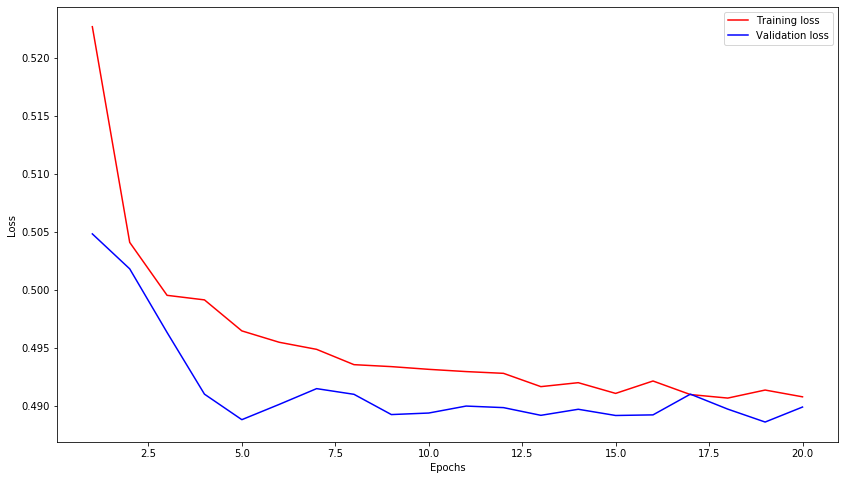

In [119]:
average_val_loss = [np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]
average_train_loss = [np.mean([x[i] for x in all_train_loss]) for i in range(num_epochs)]

average_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
average_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

print("Train loss: {}, train acc: {}".format(average_train_loss[-1], average_train_acc[-1]))
print("Val loss: {}, val acc: {}".format(average_val_loss[-1], average_val_acc[-1]))

plt.figure(figsize=(14,8))
plt.plot(range(1, len(average_train_loss) + 1), average_train_loss, color="r", label="Training loss")
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, color="b", label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [120]:
model = build_model(num_layers=2, num_nodes=256, lr=0.001, opt="Adam", dropout=True)

history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=16, verbose=1)

res = model.predict(X_test_scaled)
res = [round(num[0]) for num in res]

roc_auc_score(y_test, res)

# 1 layer, Dense(256), Dropout=False, 20 epochs, batch_size=16, Adam(0.001) : 0.61965
# 2 layer, Dense(256) * 2, Dropout=False, 20 epochs, batch_size=16, Adam(0.001) : 0.62931

Epoch 1/20
15985/15985 [==============================] - 8s 487us/step - loss: 0.5196 - accuracy: 0.7633
Epoch 2/20
15985/15985 [==============================] - 7s 430us/step - loss: 0.5014 - accuracy: 0.7732
Epoch 3/20
15985/15985 [==============================] - 7s 448us/step - loss: 0.5005 - accuracy: 0.7736
Epoch 4/20
15985/15985 [==============================] - 7s 457us/step - loss: 0.4963 - accuracy: 0.7742
Epoch 5/20
15985/15985 [==============================] - 7s 465us/step - loss: 0.4959 - accuracy: 0.7756
Epoch 6/20
15985/15985 [==============================] - 8s 476us/step - loss: 0.4956 - accuracy: 0.7742
Epoch 7/20
15985/15985 [==============================] - 8s 476us/step - loss: 0.4950 - accuracy: 0.7740
Epoch 8/20
15985/15985 [==============================] - 8s 482us/step - loss: 0.4943 - accuracy: 0.7748
Epoch 9/20
15985/15985 [==============================] - 8s 488us/step - loss: 0.4928 - accuracy: 0.7762
Epoch 10/20
15985/15985 [=====================

0.5985096791392674

In [76]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_params)

params = {'num_nodes' : [32, 64, 128, 256],
         'num_layers' : [1, 2], 
         'lr' : [0.0001, 0.001, 0.01, 0.1],
         'dropout' : [True, False],
         'opt' : ['SGD', "RMSprop", "Adam"]}

model = KerasClassifier(build_fn=build_model, epochs=50, batch_size=16)
# grid = GridSearchCV(model, param_grid=params, n_jobs=4, cv=5)
# grid.fit(X_train, y_train)

seed = 299
num_iter = 5

random_grid = RandomizedSearchCV(estimator=model, 
                                 param_distributions=params, 
                                 scoring='roc_auc', n_iter=num_iter, cv=5, n_jobs=-1,
                                 random_state=seed)
random_grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
7972/7972 [==============================] - 2s 206us/step - loss: 22.9504 - accuracy: 0.5314
Epoch 2/50
7972/7972 [==============================] - 1s 129us/step - loss: 0.7837 - accuracy: 0.5645
Epoch 3/50
7972/7972 [==============================] - 1s 132us/step - loss: 0.7313 - accuracy: 0.5871
Epoch 4/50
7972/7972 [==============================] - 1s 138us/step - loss: 0.7288 - accuracy: 0.5960
Epoch 5/50
7972/7972 [==============================] - 1s 143us/step - loss: 0.6928 - accuracy: 0.6080
Epoch 6/50
7972/7972 [==============================] - 1s 137us/step - loss: 3022.0657 - accuracy: 0.6076
Epoch 7/50
7972/7972 [==============================] - 1s 139us/step - loss: 0.6866 - accuracy: 0.6041
Epoch 8/50
7972/7972 [==============================] - 1s 144us/step - loss: 0.6828 - accuracy: 0.6136
Epoch 9/50
7972/7972 [==============================] - 1s 143us/step - loss: 0.6861 - accuracy: 0.6174
Epoch 10/50
7972/7972 [==============================] - 1s 

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a43d70090>,
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'dropout': [True, False],
                                        'lr': [0.0001, 0.001, 0.01, 0.1],
                                        'num_layers': [1, 2],
                                        'num_nodes': [32, 64, 128, 256],
                                        'opt': ['SGD', 'RMSprop', 'Adam']},
                   pre_dispatch='2*n_jobs', random_state=299, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [83]:
random_grid.cv_results_

{'mean_fit_time': array([323.6830193 , 218.12241797, 162.63273921, 224.07102652,
        235.32160497]),
 'std_fit_time': array([ 1.99630942,  7.8220918 , 14.16352113, 12.44804933, 42.12429535]),
 'mean_score_time': array([1.01736503, 1.27732596, 1.807862  , 2.59811206, 0.64059763]),
 'std_score_time': array([0.32341652, 0.24254038, 0.44929909, 0.83589727, 0.47590574]),
 'param_opt': masked_array(data=['Adam', 'RMSprop', 'RMSprop', 'Adam', 'Adam'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_num_nodes': masked_array(data=[256, 256, 64, 64, 128],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_num_layers': masked_array(data=[2, 1, 1, 2, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lr': masked_array(data=[0.1, 0.001, 0.001, 0.01, 0.001],
              mask=[False, False, False